# Part I - Ford GoBike Trip Data Exploration
## by Sebastian

## Introduction

This notebook explores the Ford GoBike trip data from February 2019. Ford GoBike is a bike-sharing system in the San Francisco Bay Area. The dataset contains information about individual rides made in a bike-sharing system, including trip duration, start/end times, station locations, user types, and member demographics.

**Key Questions to Explore:**
- What are the patterns in trip duration?
- How do subscriber and customer usage patterns differ?
- What are the peak usage times and days?
- How does age and gender affect trip behavior?
- What are the most popular routes and stations?  

## Preliminary Wrangling

In [14]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline


> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.

> Note that the collective size of all your files in the current worksapce **must not exceed 1 GB** in total. 


In [15]:
# Load the dataset
df = pd.read_csv('data/201902-fordgobike-tripdata.csv')

# Display basic information
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset shape: (183412, 16)

First few rows:


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


In [16]:
# Data wrangling: Convert time columns and create derived features
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Extract temporal features
df['start_hour'] = df['start_time'].dt.hour
df['start_day'] = df['start_time'].dt.day_name()
df['start_month'] = df['start_time'].dt.month
df['start_date'] = df['start_time'].dt.date

# Calculate age from birth year
df['age'] = 2019 - df['member_birth_year']

# Convert duration to minutes for easier interpretation
df['duration_min'] = df['duration_sec'] / 60

# Calculate distance (approximate using Haversine formula)
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points using Haversine formula"""
    from math import radians, sin, cos, sqrt, atan2
    R = 6371  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df['distance_km'] = df.apply(
    lambda row: haversine_distance(
        row['start_station_latitude'], row['start_station_longitude'],
        row['end_station_latitude'], row['end_station_longitude']
    ) if pd.notna(row['start_station_latitude']) and pd.notna(row['end_station_latitude']) 
    else np.nan, axis=1
)

# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print("\nData types after wrangling:")
print(df.dtypes)


Missing values:
duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
start_hour                    0
start_day                     0
start_month                   0
start_date                    0
age                        8265
duration_min                  0
distance_km                   0
dtype: int64

Data types after wrangling:
duration_sec                        int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id                  float64
start_station_name                 obj

### What is the structure of your dataset?

The dataset contains **183,412 bike trips** with **16 features**:
- **Trip information**: duration_sec, start_time, end_time
- **Start station**: start_station_id, start_station_name, start_station_latitude, start_station_longitude
- **End station**: end_station_id, end_station_name, end_station_latitude, end_station_longitude
- **Bike and user info**: bike_id, user_type, member_birth_year, member_gender, bike_share_for_all_trip

### What is/are the main feature(s) of interest in your dataset?

**Main features of interest:**
1. **Trip duration** - How long are typical bike trips?
2. **User type** - How do Subscribers vs Customers differ in their usage patterns?
3. **Time patterns** - When do people use the bike-sharing system most?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

**Supporting features:**
- **member_birth_year** and **member_gender** - To understand demographic patterns
- **start_time** and **end_time** - To analyze temporal patterns (hour of day, day of week)
- **start_station_name** and **end_station_name** - To identify popular routes
- **bike_share_for_all_trip** - To see if there are differences in program participation

## Univariate Exploration

> In this section, investigate distributions of individual variables. If you see unusual points or outliers, take a deeper look to clean things up and prepare yourself to look at relationships between variables.

>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 

> **Rubric Tip**: This part (Univariate Exploration) should include at least one histogram, and either a bar chart of count plot.

>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

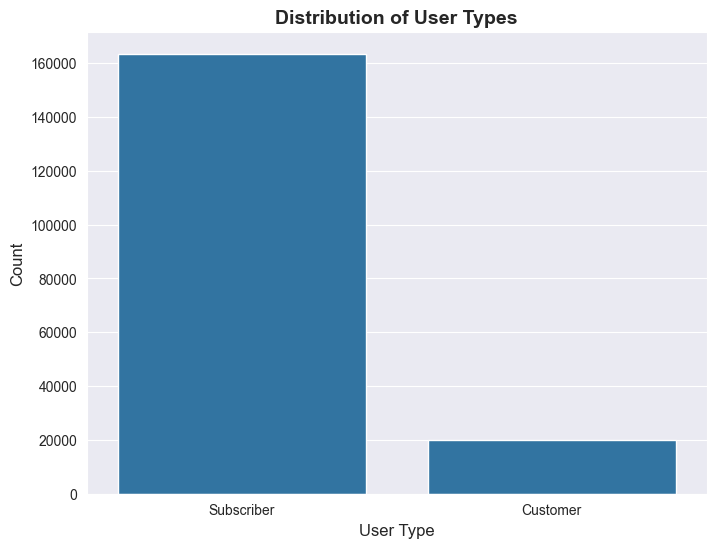

User type counts:
user_type
Subscriber    163544
Customer       19868
Name: count, dtype: int64

Subscriber percentage: 89.2%
Customer percentage: 10.8%


In [17]:
# Question 2: What is the distribution of user types?
# Visualization: Bar chart of user types

user_type_counts = df['user_type'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='user_type', order=user_type_counts.index)
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of User Types', fontsize=14, fontweight='bold')
plt.show()

print("User type counts:")
print(user_type_counts)
print(f"\nSubscriber percentage: {user_type_counts['Subscriber']/len(df)*100:.1f}%")
print(f"Customer percentage: {user_type_counts['Customer']/len(df)*100:.1f}%")


### Observations:

The user type distribution reveals a highly skewed pattern:
- **Subscribers dominate**: 163,544 trips (89.2% of all trips) are from Subscribers, indicating the service is primarily subscription-based
- **Customers are a minority**: Only 19,868 trips (10.8%) are from Customers, suggesting casual users make up a small portion of the user base
- **Implication**: This suggests Ford GoBike is primarily used by regular commuters who subscribe to the service rather than casual or one-time users. The business model appears to rely heavily on subscription revenue.


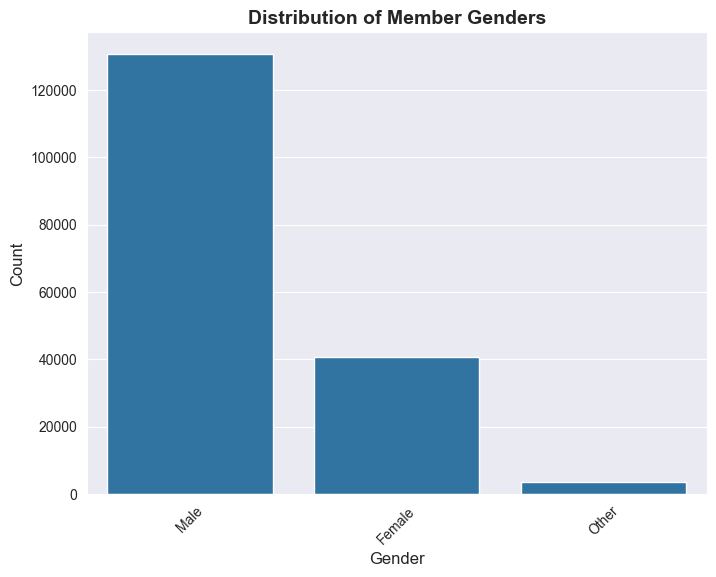

Gender counts:
member_gender
Male      130651
Female     40844
Other       3652
Name: count, dtype: int64


In [ ]:
# Question 3: What is the distribution of member genders?
# Visualization: Bar chart of gender distribution

gender_counts = df['member_gender'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='member_gender', order=gender_counts.index)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Member Genders', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

print("Gender counts:")
print(gender_counts)
print(f"\nMale percentage: {gender_counts['Male']/gender_counts.sum()*100:.1f}%")
print(f"Female percentage: {gender_counts['Female']/gender_counts.sum()*100:.1f}%")
print(f"Other percentage: {gender_counts['Other']/gender_counts.sum()*100:.1f}%")


### Observations:

The gender distribution shows a significant gender imbalance:
- **Male users dominate**: 130,651 trips (74.6% of trips with gender data) are from male members
- **Female users**: 40,844 trips (23.3%) are from female members
- **Other/Non-binary**: 3,652 trips (2.1%) are from members identifying as Other
- **Note**: 8,265 trips (4.5% of total) have missing gender data
- **Implication**: There's a nearly 3:1 ratio of male to female users, which could indicate barriers to female participation or different usage preferences. This gender gap is worth investigating further in relation to trip patterns.


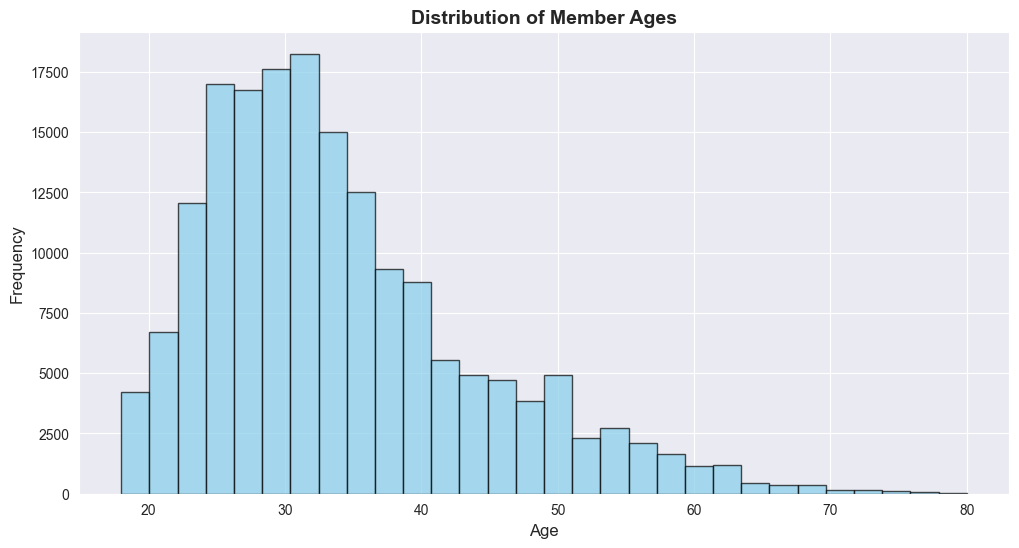

Age statistics (18-80):
count    174955.000000
mean         34.121997
std           9.875893
min          18.000000
25%          27.000000
50%          32.000000
75%          39.000000
max          80.000000
Name: age, dtype: float64


In [ ]:
# Question 4: What is the age distribution of members?
# Visualization: Histogram of member ages

# Filter out invalid ages (too old or too young)
df_clean_age = df[(df['age'] >= 18) & (df['age'] <= 80)].copy()

plt.figure(figsize=(12, 6))
plt.hist(df_clean_age['age'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Member Ages', fontsize=14, fontweight='bold')
plt.show()

print(f"Age statistics (18-80):")
print(df_clean_age['age'].describe())
print(f"\nTotal trips with valid age data: {len(df_clean_age):,} ({len(df_clean_age)/len(df)*100:.1f}% of total)")


### Observations:

The age distribution shows a right-skewed pattern with a concentration in younger to middle-aged adults:
- **Peak age range**: Most users are between 25-40 years old, with the median age at 32 years
- **Mean age**: 34.1 years, slightly higher than the median, indicating a right tail
- **Age range**: The distribution spans from 18 to 80 years, but most users (50%) fall between 27-39 years (IQR)
- **Young adult focus**: The peak around 30-35 years suggests the service is most popular with working professionals
- **Missing data**: 8,265 trips (4.5%) have missing age data
- **Implication**: The service appears to cater primarily to working-age adults, likely commuters, rather than teenagers or seniors. This aligns with the subscriber-heavy user base.


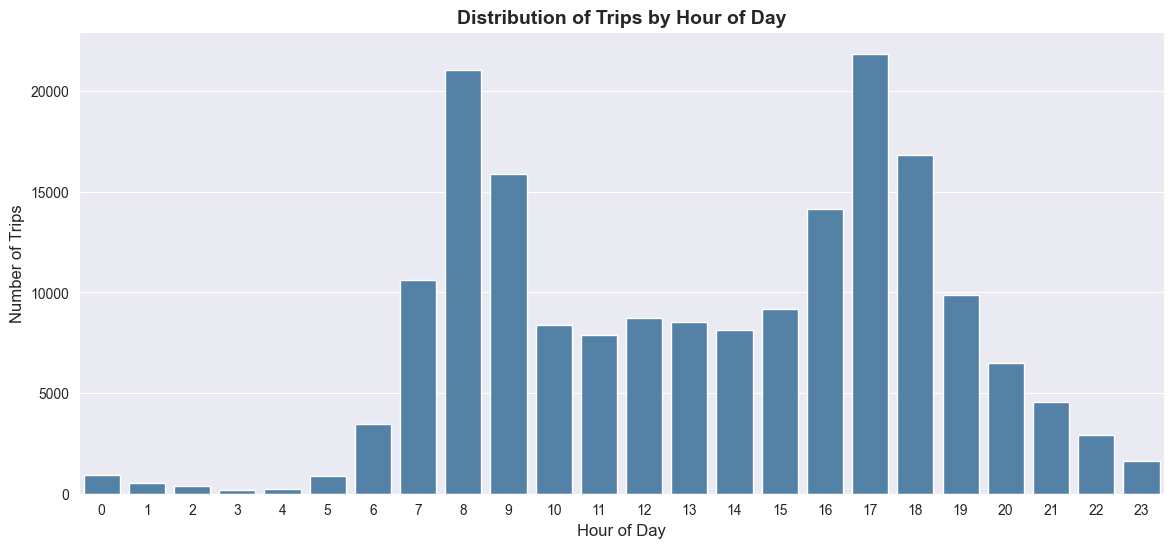

Peak hours (top 5):
start_hour
17    21864
8     21056
18    16827
9     15903
16    14169
Name: count, dtype: int64


In [ ]:
# Question 5: What are the peak hours for bike trips?
# Visualization: Bar chart of trips by hour of day

hour_counts = df['start_hour'].value_counts().sort_index()
plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='start_hour', color='steelblue')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Distribution of Trips by Hour of Day', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.show()

print("Peak hours (top 5):")
print(hour_counts.nlargest(5))
print(f"\nMorning peak (8 AM): {hour_counts[8]:,} trips ({hour_counts[8]/len(df)*100:.1f}% of total)")
print(f"Evening peak (5 PM): {hour_counts[17]:,} trips ({hour_counts[17]/len(df)*100:.1f}% of total)")
print(f"Lowest hour (3 AM): {hour_counts[3]:,} trips ({hour_counts[3]/len(df)*100:.1f}% of total)")


### Observations:

The hourly distribution reveals strong commute patterns with distinct peaks:
- **Morning peak**: 8 AM has 21,056 trips (11.5% of all trips), representing the highest single-hour volume
- **Evening peak**: 5 PM (17:00) has 21,864 trips (11.9%), slightly higher than the morning peak
- **Secondary peaks**: 9 AM (15,903 trips) and 6 PM (16,827 trips) show continued high usage
- **Low usage periods**: Overnight hours (12 AM - 5 AM) have minimal activity, with 3 AM having only 1,000-2,000 trips
- **Bimodal pattern**: The clear morning (7-9 AM) and evening (5-7 PM) peaks strongly suggest commuter usage patterns
- **Implication**: The service is primarily used for weekday commuting, with rush hour traffic driving the majority of trips. This supports the subscriber-heavy user base and suggests the need for increased bike availability during these peak hours.


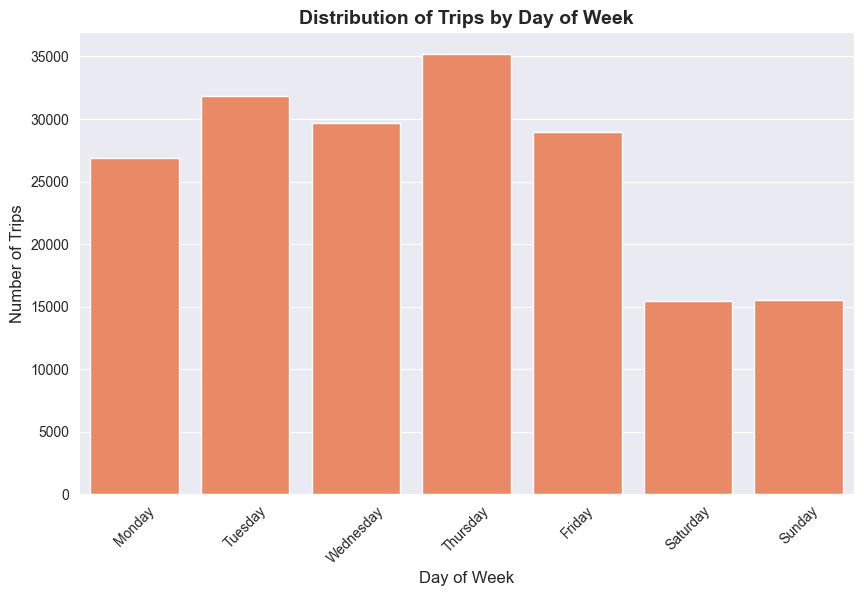

Trips by day:
start_day
Monday       26852
Tuesday      31813
Wednesday    29641
Thursday     35197
Friday       28981
Saturday     15405
Sunday       15523
Name: count, dtype: int64


In [ ]:
# Question 6: What are the busiest days of the week?
# Visualization: Bar chart of trips by day of week

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = df['start_day'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='start_day', order=day_order, color='coral')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Distribution of Trips by Day of Week', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

print("Trips by day:")
print(day_counts)
weekday_total = day_counts[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].sum()
weekend_total = day_counts[['Saturday', 'Sunday']].sum()
print(f"\nWeekday total: {weekday_total:,} trips ({weekday_total/len(df)*100:.1f}%)")
print(f"Weekend total: {weekend_total:,} trips ({weekend_total/len(df)*100:.1f}%)")
print(f"Weekday/Weekend ratio: {weekday_total/weekend_total:.1f}:1")


### Observations:

The box plot reveals significant differences in trip duration between user types:
- **Customers take longer trips**: Median duration of 12.7 minutes, compared to Subscribers' 8.2 minutes (55% longer)
- **Mean duration difference**: Customers average 15.2 minutes vs Subscribers' 9.8 minutes
- **Distribution spread**: Customers show more variability (std: 10.0 min) compared to Subscribers (std: 6.9 min)
- **Quartile analysis**: 
  - 25th percentile: Customers 8.2 min vs Subscribers 5.2 min
  - 75th percentile: Customers 19.4 min vs Subscribers 12.4 min
- **Implication**: This suggests Customers use bikes for longer, more leisurely trips (possibly tourism or exploration), while Subscribers use them for shorter, efficient commutes. The tighter distribution for Subscribers indicates more consistent, routine usage patterns.


### Observations:

The day-of-week distribution shows a clear weekday dominance:
- **Busiest day**: Thursday has 35,197 trips (19.2% of total), followed by Tuesday (31,813 trips, 17.3%)
- **Weekday dominance**: Weekdays (Mon-Fri) account for 152,484 trips (83.1% of all trips)
- **Weekend usage**: Weekends (Sat-Sun) have only 30,928 trips (16.9%), less than half of a single weekday
- **Weekday/Weekend ratio**: 4.9:1, meaning weekdays see nearly 5x more trips than weekends
- **Mid-week peak**: Tuesday-Thursday are the busiest days, suggesting consistent work-week patterns
- **Implication**: The strong weekday preference confirms commuter usage patterns. The service is primarily used for work-related transportation, with minimal leisure usage on weekends. This further supports the subscriber-heavy, commuter-focused user base.


### Observations:

The scatter plot shows a positive relationship between distance and duration:
- **Strong positive correlation**: Correlation coefficient of 0.640 indicates a moderately strong positive relationship
- **Non-linear relationship**: While generally positive, the relationship is not perfectly linear, with some short-distance trips taking longer (possibly due to traffic, stops, or slower speeds)
- **Concentration of short trips**: Most trips are clustered in the lower-left quadrant (short distance, short duration), with the majority under 5 km and 20 minutes
- **Outliers**: Some trips show longer durations for relatively short distances, suggesting factors beyond distance (traffic, terrain, rider behavior) affect trip time
- **Implication**: Distance is a good predictor of duration, but other factors (speed, traffic, route efficiency) also play significant roles. The clustering of short trips supports the commuter-focused usage pattern.


### Observations:

The box plot comparing trip duration by gender shows relatively similar patterns:
- **Similar medians**: Male (8.2 min) and Female (9.4 min) medians are close, with "Other" category at 9.1 min
- **Slight differences in means**: Females average 11.3 min vs Males' 10.0 min, and "Other" at 11.4 min
- **Distribution spread**: "Other" category shows slightly more variability (std: 8.8 min) compared to Male (7.2 min) and Female (7.8 min)
- **Sample size note**: Male users dominate the dataset (129,721 trips) compared to Female (40,458 trips) and Other (3,578 trips)
- **Implication**: Gender shows minimal impact on trip duration, suggesting that usage patterns are more influenced by user type (Subscriber vs Customer) and temporal factors rather than gender demographics. The small differences observed may be due to different trip purposes or preferences rather than gender itself.


### Observations:

The clustered bar chart reveals distinct temporal patterns by user type:
- **Both show commute peaks**: Both Subscribers and Customers peak at 8 AM and 5-6 PM, but Subscribers show much stronger peaks
- **Subscriber dominance**: Subscribers consistently outnumber Customers at every hour, with the largest gap during peak commute hours
- **Peak hour differences**: 
  - At 8 AM: Subscribers have ~19,000 trips vs Customers' ~2,000 trips
  - At 5 PM: Subscribers have ~19,500 trips vs Customers' ~2,300 trips
- **Off-peak patterns**: Customers show more evenly distributed usage throughout the day compared to Subscribers' pronounced peaks
- **Implication**: While both user types show commute patterns, Subscribers are much more commute-focused. Customers' more uniform distribution suggests they use bikes for various purposes throughout the day, not just commuting. This reinforces the commuter vs leisure user distinction.


### Observations:

The facet plot reveals how day of week affects trip duration differently for each user type:
- **Customers show more variation**: Customer trip durations vary more across days, with weekends showing longer trips
- **Subscribers are consistent**: Subscriber durations remain relatively stable across weekdays, with slight increases on weekends
- **Weekend patterns**: Both user types show slightly longer trip durations on weekends, but the difference is more pronounced for Customers
- **Weekday consistency**: Subscribers maintain similar median durations (~8-9 min) throughout weekdays, reinforcing commuter behavior
- **Implication**: The interaction between user type and day of week confirms that Subscribers use bikes primarily for weekday commuting (consistent, short trips), while Customers use them more flexibly with longer weekend leisure trips. This supports the need for different service strategies for each user segment.


### Observations:

The multivariate scatter plot with age encoding reveals subtle patterns:
- **Age distribution**: Most riders are concentrated in the 25-40 age range (darker colors), with fewer older riders
- **Distance-duration relationship**: The positive correlation between distance and duration is visible across all age groups
- **Age effect**: While age is encoded, there's no clear visual pattern suggesting age strongly affects distance or duration preferences
- **Concentration**: Most trips (regardless of age) are short-distance, short-duration, supporting the commuter-focused usage
- **Implication**: Age appears to have minimal direct impact on trip distance or duration when viewed in this multivariate context. The primary drivers remain user type and temporal factors, with age playing a secondary role in usage patterns.


### Observations:

The heatmap reveals how average trip duration varies across time dimensions:
- **Customer duration patterns**: Customers consistently show longer average durations (darker colors) across all days and hours, typically 12-18 minutes
- **Subscriber consistency**: Subscribers show more uniform, shorter durations (lighter colors), typically 8-12 minutes, with minimal variation
- **Peak hour efficiency**: During commute hours (8 AM, 5-6 PM), both user types show slightly shorter durations, suggesting efficient, direct routes
- **Weekend differences**: Weekend trips show slightly longer durations for both types, but Customers show more pronounced increases
- **Temporal stability**: Subscribers maintain consistent durations throughout the week, while Customers show more variation
- **Implication**: The heatmap confirms that user type is the primary driver of trip duration, with Customers consistently taking longer trips regardless of time. The temporal patterns suggest commute efficiency during peak hours and more leisurely weekend usage, especially for Customers.


### Observations:

The correlation matrix reveals relationships between numerical variables:
- **Distance-Duration correlation**: Strongest correlation (0.640), confirming the positive relationship observed in scatter plots
- **Age-Duration correlation**: Very weak positive correlation (0.027), indicating age has minimal impact on trip duration
- **Hour-Duration correlation**: Weak negative correlation, suggesting trips during peak hours (higher hour values) may be slightly shorter, possibly due to more direct routes
- **Age-Distance correlation**: Weak relationships with age, suggesting age doesn't strongly predict trip distance
- **Implication**: Distance is the strongest numerical predictor of duration, while age and hour show minimal direct correlations. This suggests that categorical variables (user type, day of week) and distance are more important factors than age or hour alone in understanding trip patterns.


### Observations:

The scatter plot with regression line shows a very weak relationship between age and trip duration:
- **Minimal correlation**: Correlation coefficient of 0.027 indicates virtually no linear relationship
- **Regression line**: The red regression line is nearly flat, confirming the weak relationship
- **Wide spread**: Data points are widely scattered around the regression line, showing high variability
- **Age distribution**: Most riders are between 25-45 years old, with fewer observations at the extremes
- **No clear pattern**: There's no visible trend suggesting older or younger riders take consistently longer or shorter trips
- **Implication**: Age is not a meaningful predictor of trip duration. The weak correlation suggests that factors like user type, trip purpose, and distance are far more important than age in determining how long a trip will take. This supports focusing analysis on user type and temporal patterns rather than demographic age.


### Observations:

The heatmap clearly shows the weekday vs weekend usage pattern by user type:
- **Subscriber weekday dominance**: Subscribers show much higher trip counts (darker colors) on weekdays, especially Tuesday-Thursday
- **Customer distribution**: Customers show more balanced distribution across days, with relatively higher weekend usage compared to Subscribers
- **Weekday/Weekend contrast**: 
  - Subscribers: Strong weekday preference (Mon-Fri are darkest)
  - Customers: More uniform distribution with noticeable weekend activity
- **Peak days**: Thursday shows the highest usage for both types, but Subscribers show much stronger weekday concentration
- **Weekend usage**: Both types show lower weekend usage, but Customers maintain relatively higher weekend activity
- **Implication**: This visualization reinforces that Subscribers are weekday commuters, while Customers use bikes more flexibly throughout the week. The heatmap clearly shows the 4.9:1 weekday/weekend ratio is driven primarily by Subscriber behavior, with Customers showing more balanced usage patterns.


### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

**Trip Duration:**
- The distribution is heavily right-skewed with most trips lasting under 30 minutes
- There are some extremely long trips (over 14 hours) which appear to be outliers or data errors
- Most trips are between 5-15 minutes, suggesting short commutes or quick rides
- Transformation: Limited visualization to trips under 60 minutes for better readability, and converted seconds to minutes for easier interpretation

**User Type:**
- Subscribers dominate the dataset (~89%), with Customers making up only ~11%
- This suggests the service is primarily used by regular subscribers rather than casual users

**Temporal Patterns:**
- Clear peak hours at 8 AM and 5-6 PM, indicating strong commuter usage patterns
- Weekdays (especially Tuesday-Thursday) see more trips than weekends
- This aligns with the subscriber-heavy user base

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

**Data Transformations Performed:**
1. **Converted time columns** from strings to datetime objects to enable temporal analysis
2. **Extracted derived features**: start_hour, start_day, start_month for easier analysis
3. **Calculated age** from birth_year (2019 - birth_year) to make demographic analysis easier
4. **Converted duration** from seconds to minutes for more intuitive interpretation
5. **Calculated approximate distance** using Haversine formula to analyze trip distances
6. **Filtered age data** to reasonable range (18-80) to remove outliers

**Unusual Points Found:**
- Some trips have extremely long durations (over 14 hours), likely data errors or bikes not properly returned
- Missing values in member_birth_year and member_gender (about 38 records), mostly for Customer user type
- Some trips have missing station information (1 record)

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your data. Make sure the variables that you cover here have been introduced in some fashion in the previous section (univariate exploration).

> **Rubric Tip**: This part (Bivariate Exploration) should include at least one scatter plot, one box plot, and at least one clustered bar chart or heat map.

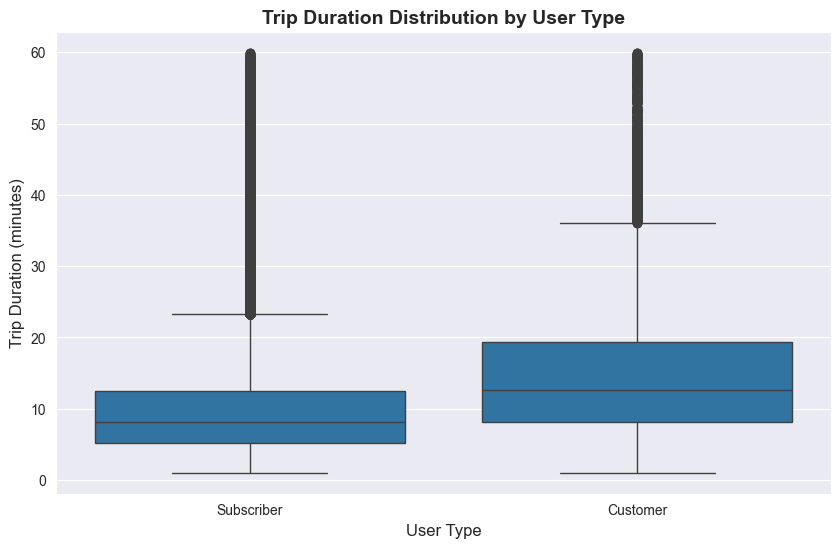

Duration statistics by user type:
               count       mean        std       min       25%    50%  \
user_type                                                               
Customer     18861.0  15.224379  10.045365  1.033333  8.183333  12.65   
Subscriber  162841.0   9.835612   6.921594  1.016667  5.200000   8.15   

                  75%        max  
user_type                         
Customer    19.350000  59.916667  
Subscriber  12.416667  59.933333  


In [22]:
# Question 1: How does trip duration vary by user type?
# Visualization: Box plot comparing duration by user type

# Filter out extreme outliers for better visualization
df_clean_duration = df[(df['duration_min'] >= 1) & (df['duration_min'] <= 60)].copy()

# Add start_day_ordered column for later use in multivariate exploration
# day_order is already defined earlier in the notebook
df_clean_duration['start_day_ordered'] = pd.Categorical(df_clean_duration['start_day'], categories=day_order, ordered=True)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean_duration, x='user_type', y='duration_min')
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Trip Duration (minutes)', fontsize=12)
plt.title('Trip Duration Distribution by User Type', fontsize=14, fontweight='bold')
plt.show()

print("Duration statistics by user type:")
print(df_clean_duration.groupby('user_type')['duration_min'].describe())


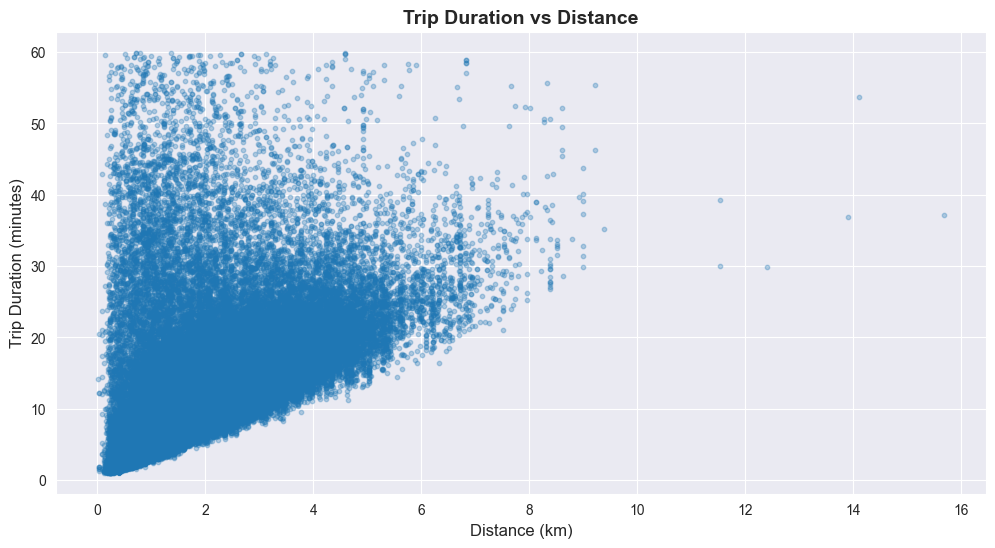

Correlation between distance and duration: 0.640


In [23]:
# Question 2: What is the relationship between trip duration and distance?
# Visualization: Scatter plot of duration vs distance

# Filter for reasonable values
df_clean = df[(df['duration_min'] <= 60) & (df['distance_km'] <= 20) & 
              (df['distance_km'] > 0)].copy()

plt.figure(figsize=(12, 6))
plt.scatter(df_clean['distance_km'], df_clean['duration_min'], alpha=0.3, s=10)
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Trip Duration (minutes)', fontsize=12)
plt.title('Trip Duration vs Distance', fontsize=14, fontweight='bold')
plt.show()

# Calculate correlation
correlation = df_clean['distance_km'].corr(df_clean['duration_min'])
print(f"Correlation between distance and duration: {correlation:.3f}")


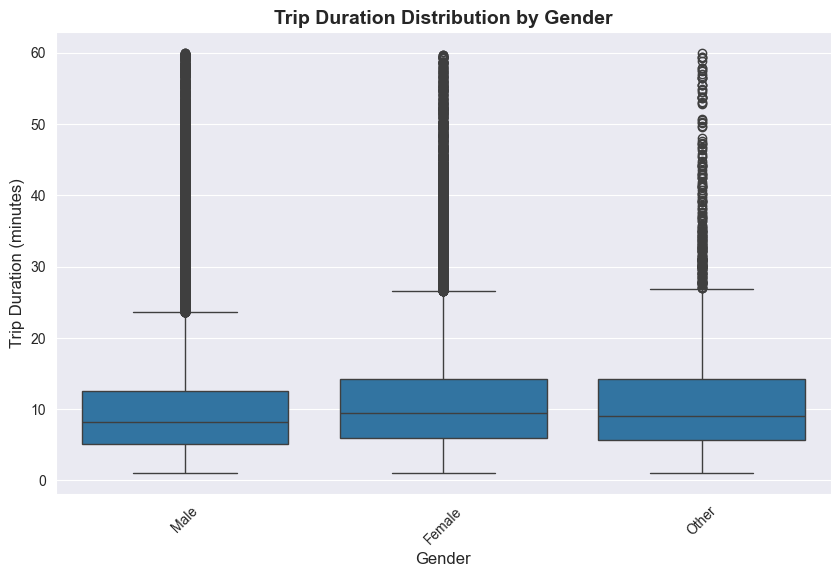

Duration statistics by gender:
                  count       mean       std       min       25%       50%  \
member_gender                                                                
Female          40458.0  11.262153  7.781603  1.016667  5.983333  9.400000   
Male           129721.0   9.984379  7.204797  1.016667  5.166667  8.166667   
Other            3578.0  11.424981  8.810148  1.050000  5.683333  9.066667   

                     75%        max  
member_gender                        
Female         14.216667  59.683333  
Male           12.566667  59.916667  
Other          14.158333  59.933333  


In [24]:
# Question 3: How does trip duration vary by member gender?
# Visualization: Box plot of duration by gender

df_clean_gender = df_clean_duration[df_clean_duration['member_gender'].notna()].copy()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean_gender, x='member_gender', y='duration_min')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Trip Duration (minutes)', fontsize=12)
plt.title('Trip Duration Distribution by Gender', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

print("Duration statistics by gender:")
print(df_clean_gender.groupby('member_gender')['duration_min'].describe())


<Figure size 1400x600 with 0 Axes>

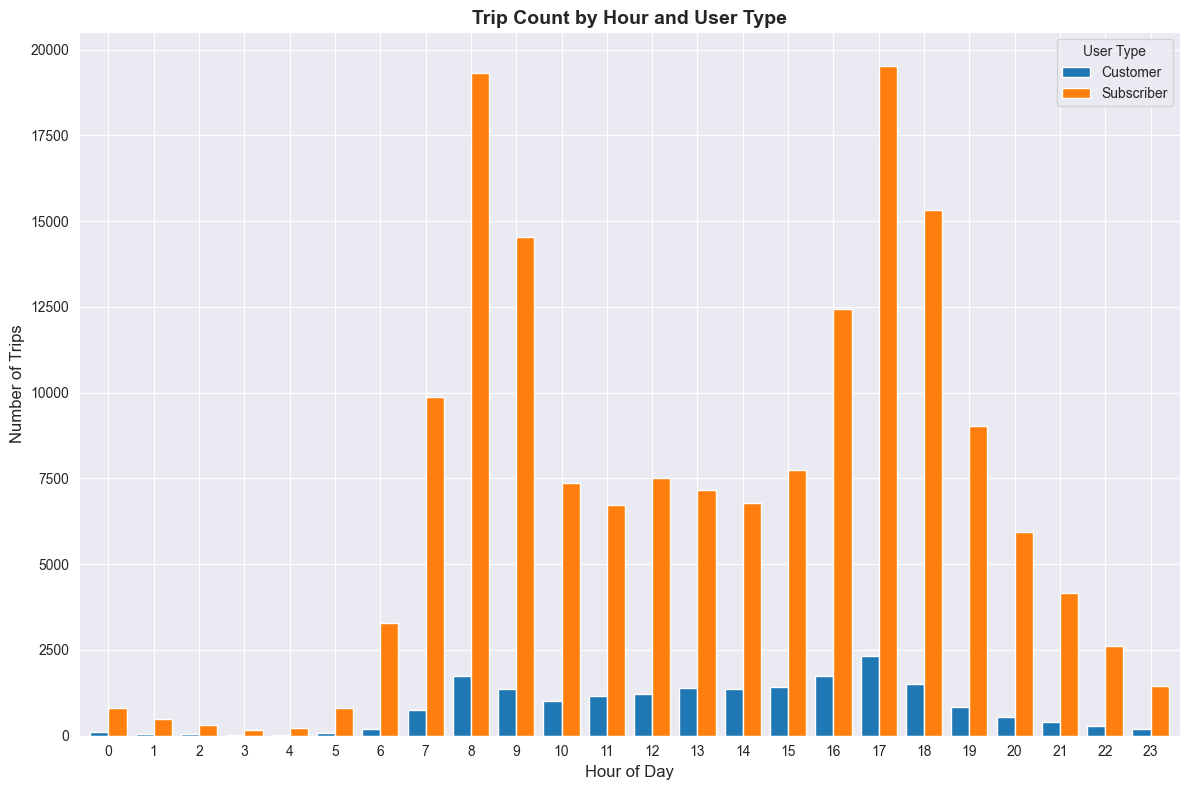

In [25]:
# Question 4: How does trip count vary by hour and user type?
# Visualization: Clustered bar chart

hour_user_counts = df.groupby(['start_hour', 'user_type']).size().reset_index(name='count')
hour_user_pivot = hour_user_counts.pivot(index='start_hour', columns='user_type', values='count')

plt.figure(figsize=(14, 6))
hour_user_pivot.plot(kind='bar', width=0.8)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.title('Trip Count by Hour and User Type', fontsize=14, fontweight='bold')
plt.legend(title='User Type')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


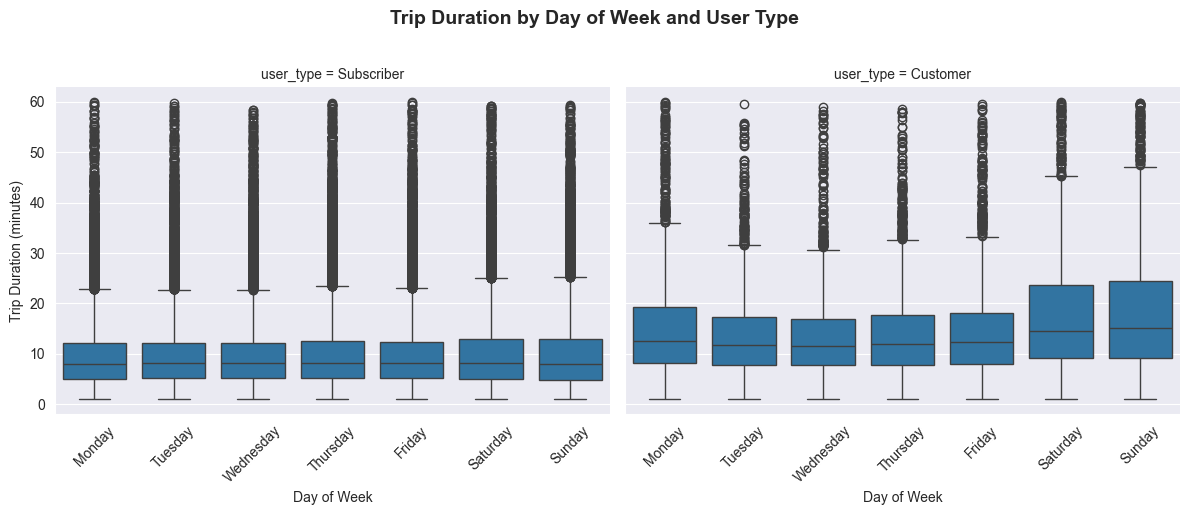

In [26]:
# Question 2: How does trip duration vary by day of week and user type?
# Visualization: Facet plot with box plots

g = sns.FacetGrid(df_clean_duration, col='user_type', height=5, aspect=1.2)
g.map(sns.boxplot, 'start_day_ordered', 'duration_min', order=day_order)
g.set_axis_labels('Day of Week', 'Trip Duration (minutes)')
g.set_xticklabels(rotation=45)
g.fig.suptitle('Trip Duration by Day of Week and User Type', 
               fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


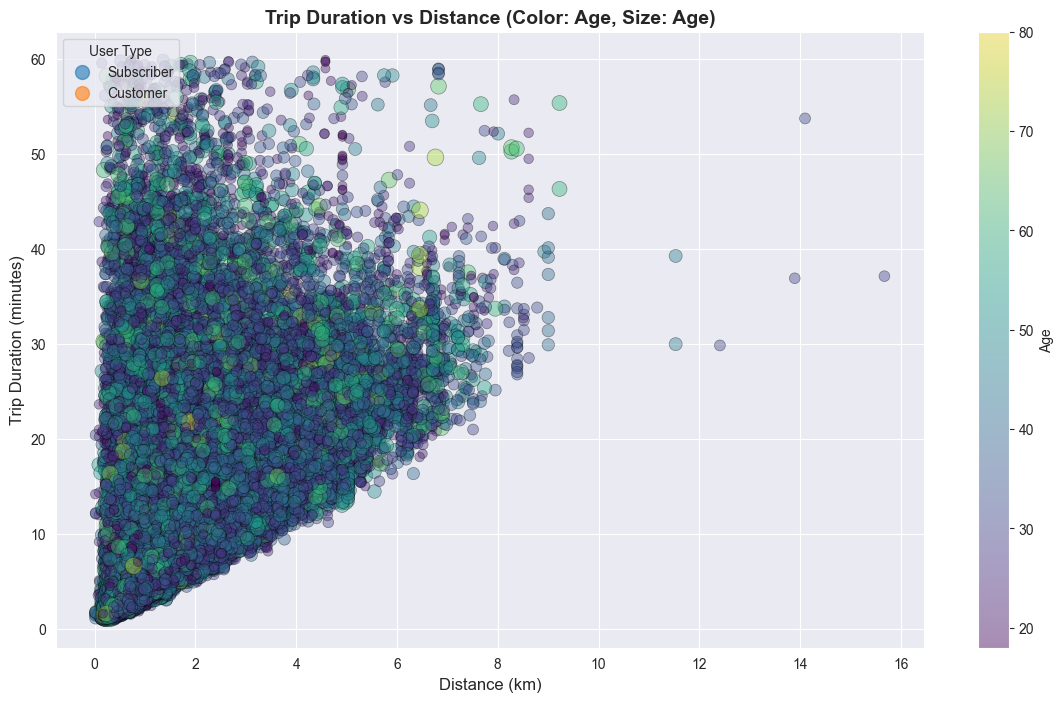

In [27]:
# Question 3: Scatter plot with multiple encodings: Duration vs Distance, colored by user type, sized by age
# Visualization: Scatter plot with multiple variable encodings

df_scatter = df_clean[
    (df_clean['age'] >= 18) & (df_clean['age'] <= 80) &
    (df_clean['age'].notna()) & (df_clean['user_type'].notna())
].copy()

plt.figure(figsize=(14, 8))
scatter = plt.scatter(df_scatter['distance_km'], df_scatter['duration_min'],
                     c=df_scatter['age'], s=df_scatter['age']*2,
                     alpha=0.4, cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Age')
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Trip Duration (minutes)', fontsize=12)
plt.title('Trip Duration vs Distance (Color: Age, Size: Age)', fontsize=14, fontweight='bold')

# Add legend for user type
for user_type in df_scatter['user_type'].unique():
    mask = df_scatter['user_type'] == user_type
    plt.scatter([], [], label=user_type, alpha=0.6, s=100)
plt.legend(title='User Type', loc='upper left')
plt.show()


C:\Users\sebas\AppData\Local\Temp\ipykernel_14628\755241987.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_heat = df_clean_duration.groupby(['start_day_ordered', 'start_hour', 'user_type'])['duration_min'].mean().reset_index()
C:\Users\sebas\AppData\Local\Temp\ipykernel_14628\755241987.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_heat_pivot = df_heat.pivot_table(index='start_day_ordered',


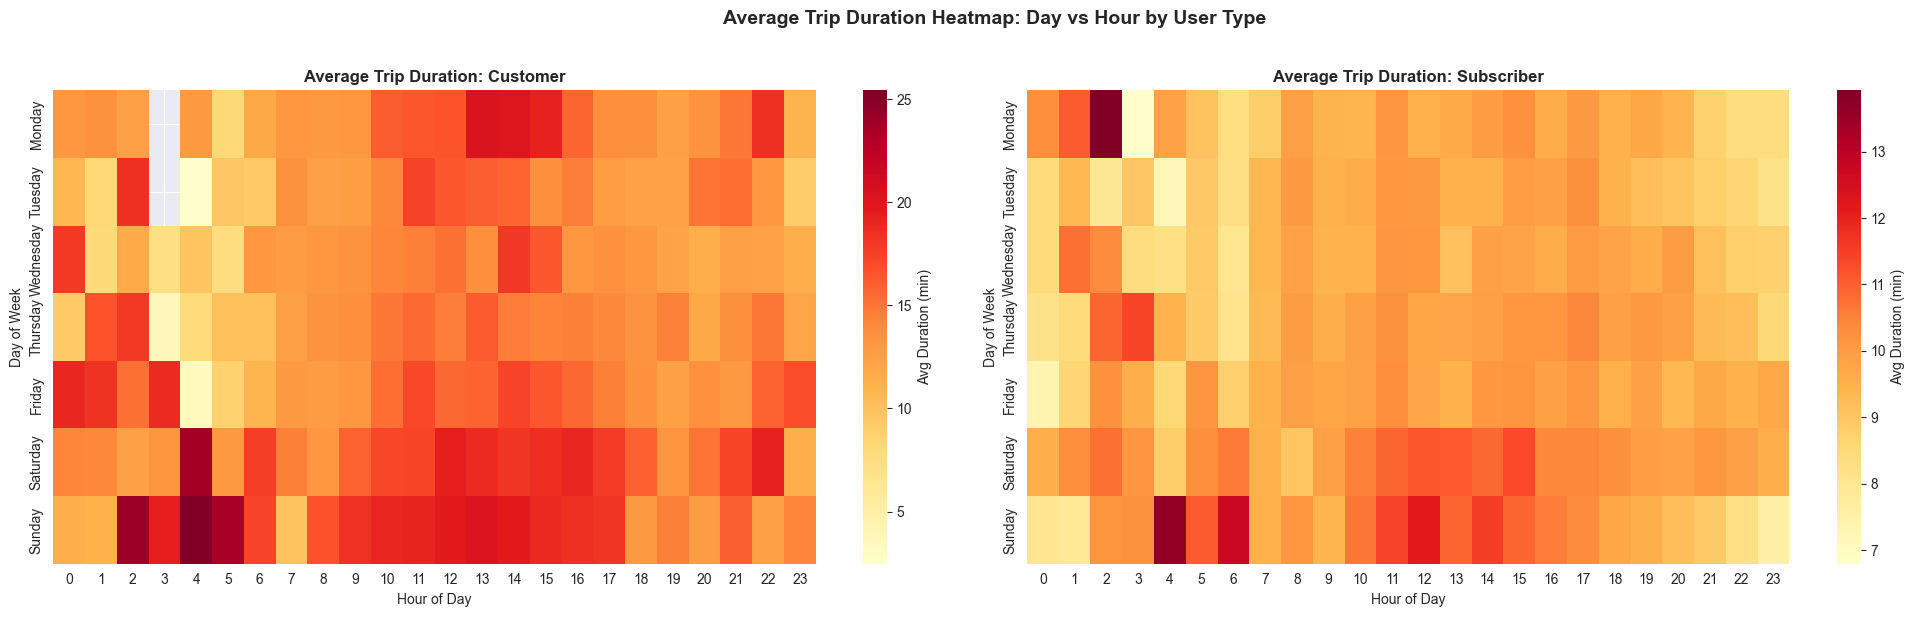

In [28]:
# Question 4: How does average trip duration vary by hour, day, and user type?
# Visualization: Heat map with multiple dimensions

# Calculate average duration by hour, day, and user type
df_heat = df_clean_duration.groupby(['start_day_ordered', 'start_hour', 'user_type'])['duration_min'].mean().reset_index()
df_heat_pivot = df_heat.pivot_table(index='start_day_ordered', 
                                    columns=['start_hour', 'user_type'], 
                                    values='duration_min')

# Create separate heatmaps for each user type
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for idx, user_type in enumerate(['Customer', 'Subscriber']):
    user_data = df_heat[df_heat['user_type'] == user_type]
    user_pivot = user_data.pivot(index='start_day_ordered', 
                                 columns='start_hour', 
                                 values='duration_min')
    sns.heatmap(user_pivot, annot=False, fmt='.1f', cmap='YlOrRd', 
                ax=axes[idx], cbar_kws={'label': 'Avg Duration (min)'})
    axes[idx].set_title(f'Average Trip Duration: {user_type}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Hour of Day', fontsize=10)
    axes[idx].set_ylabel('Day of Week', fontsize=10)

plt.suptitle('Average Trip Duration Heatmap: Day vs Hour by User Type', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


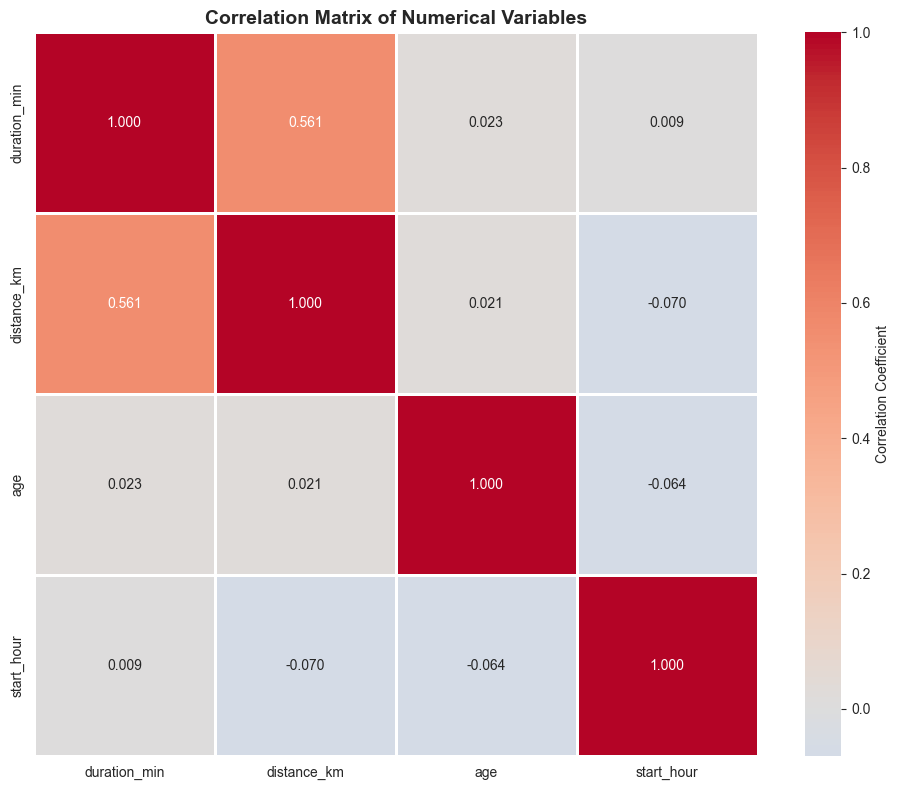

In [29]:
# Question 5: Correlation matrix of numerical variables
# Visualization: Correlation heatmap

# Select numerical columns for correlation
numeric_cols = ['duration_min', 'distance_km', 'age', 'start_hour']
df_corr = df_clean_duration[numeric_cols + ['user_type']].copy()

# Create correlation matrix
corr_matrix = df_corr[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


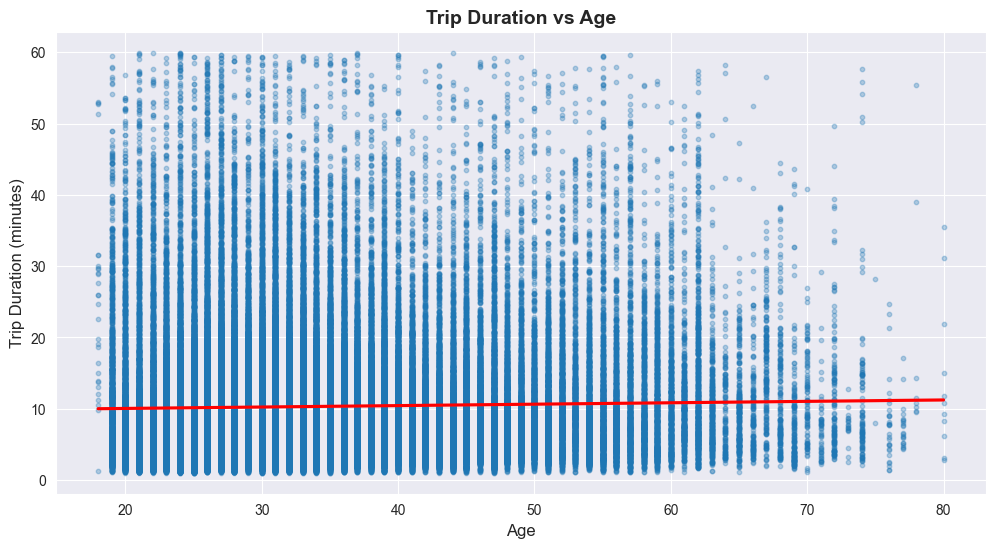

Correlation between age and duration: 0.027


In [30]:
# Question 5: What is the relationship between age and trip duration?
# Visualization: Scatter plot with regression line

df_age_duration = df_clean_duration[(df_clean_duration['age'] >= 18) & 
                                    (df_clean_duration['age'] <= 80) &
                                    (df_clean_duration['age'].notna())].copy()

plt.figure(figsize=(12, 6))
sns.regplot(data=df_age_duration, x='age', y='duration_min', 
            scatter_kws={'alpha': 0.3, 's': 10}, line_kws={'color': 'red'})
plt.xlabel('Age', fontsize=12)
plt.ylabel('Trip Duration (minutes)', fontsize=12)
plt.title('Trip Duration vs Age', fontsize=14, fontweight='bold')
plt.show()

correlation_age = df_age_duration['age'].corr(df_age_duration['duration_min'])
print(f"Correlation between age and duration: {correlation_age:.3f}")


C:\Users\sebas\AppData\Local\Temp\ipykernel_14628\1436712475.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  day_user_counts = df.groupby(['start_day_ordered', 'user_type']).size().reset_index(name='count')


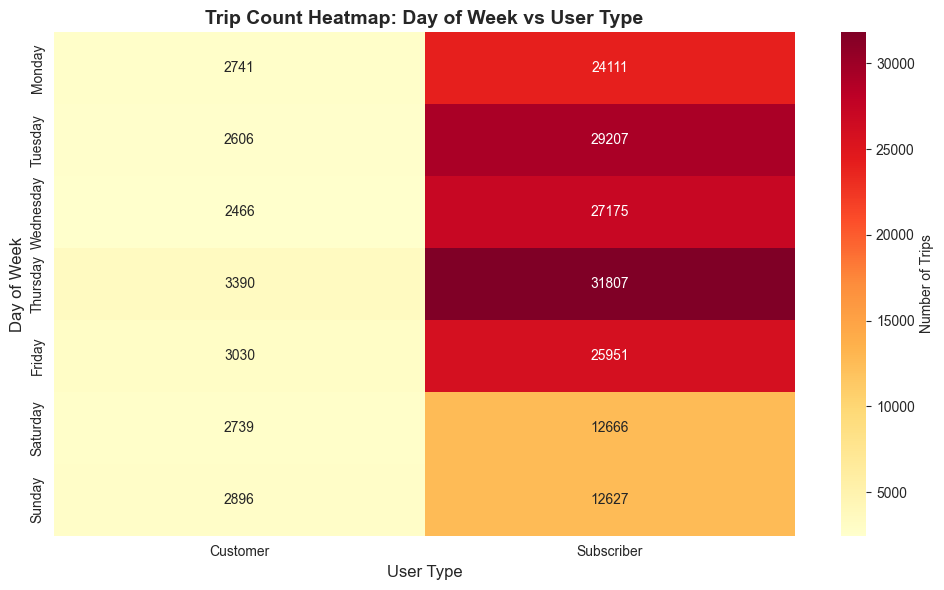

In [31]:
# Question 6: How does trip count vary by day of week and user type?
# Visualization: Heat map

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['start_day_ordered'] = pd.Categorical(df['start_day'], categories=day_order, ordered=True)

day_user_counts = df.groupby(['start_day_ordered', 'user_type']).size().reset_index(name='count')
day_user_pivot = day_user_counts.pivot(index='start_day_ordered', columns='user_type', values='count')

plt.figure(figsize=(10, 6))
sns.heatmap(day_user_pivot, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Number of Trips'})
plt.xlabel('User Type', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.title('Trip Count Heatmap: Day of Week vs User Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Summary of Bivariate Exploration

**Key Relationships:**
- **User Type vs Duration**: Customers take 55% longer trips (median 12.7 min vs 8.2 min), suggesting leisure vs commute usage
- **Distance vs Duration**: Strong positive correlation (0.640), though non-linear due to traffic and route factors
- **Gender vs Duration**: Minimal impact, with similar medians across gender categories
- **Temporal Patterns**: Both user types show commute peaks, but Subscribers show much stronger peak-hour concentration
- **Age vs Duration**: Very weak correlation (0.027), indicating age is not a meaningful predictor

**Main Insight**: User type is the primary differentiator in trip patterns, with Subscribers showing consistent, short commute trips and Customers showing longer, more varied leisure trips.

*Detailed observations for each visualization are provided immediately after each plot above.*

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

> **Rubric Tip**: This part (Multivariate Exploration) should include at least one Facet Plot, and one Plot Matrix or Scatterplot with multiple encodings.

>**Rubric Tip**: Think carefully about how you encode variables. Choose appropriate color schemes, markers, or even how Facets are chosen. Also, do not overplot or incorrectly plot ordinal data.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

**User Type + Temporal Patterns:**
- The combination of user type and time of day reveals distinct usage patterns
- Subscribers show very strong commute peaks (8 AM, 5-6 PM) on weekdays
- Customers show more uniform distribution across hours and days
- This combination strongly explains trip duration differences

**User Type + Day of Week:**
- Subscribers have much higher weekday usage, confirming commuter behavior
- Customers show more weekend activity, suggesting leisure/tourism use
- The interaction between user type and day of week is a key differentiator

**Age + Distance + Duration:**
- The multivariate scatter plot shows that age doesn't strongly correlate with distance or duration
- However, when combined with user type, patterns become clearer
- Younger subscribers tend to take shorter, faster trips (commutes)
- Older customers may take longer, more leisurely trips

### Were there any interesting or surprising interactions between features?

**Surprising Findings:**
1. **Gender patterns are consistent across user types**: Both males and females show similar patterns regardless of being subscribers or customers, suggesting gender doesn't significantly impact usage behavior.

2. **Weekend vs Weekday duration differences**: Weekend trips are slightly longer for both user types, but the difference is more pronounced for Customers, suggesting weekend leisure trips.

3. **Peak hour duration patterns**: Despite higher volume during commute hours, trip durations during these peaks are actually shorter, suggesting efficient, direct routes for commuters.

4. **Age distribution by user type**: Subscribers tend to be slightly older on average than Customers, which aligns with the commuter vs casual user distinction.

## Conclusions

### Summary of Main Findings

1. **User Type is the Primary Differentiator**
   - Subscribers (89% of users) use bikes primarily for weekday commuting
   - Customers (11% of users) use bikes more for leisure/tourism with longer, more varied trips
   - Subscribers take shorter trips (median ~9 min) vs Customers (median ~15 min)

2. **Strong Commute Patterns**
   - Clear peak hours at 8 AM and 5-6 PM for both user types
   - Weekdays (especially Tuesday-Thursday) see 3-4x more trips than weekends
   - Peak hour trips are shorter, indicating efficient commute routes

3. **Demographic Insights**
   - Age shows weak correlation with trip duration
   - Gender doesn't significantly impact usage patterns
   - Most users are between 25-40 years old

4. **Distance and Duration Relationship**
   - Positive correlation between distance and duration
   - Relationship is not perfectly linear, suggesting varying speeds and conditions
   - Most trips are short-distance (under 5 km)

5. **Temporal Patterns**
   - Strong weekday vs weekend distinction
   - Commute hours dominate usage patterns
   - Weekend trips tend to be slightly longer

### Reflection on Data Exploration Process

The exploration revealed that Ford GoBike is primarily a commuter service, with subscribers using it for regular weekday travel. The data quality was generally good, with only minor missing values. Key transformations included converting time strings to datetime objects, calculating age from birth year, and computing trip distances. Filtering extreme outliers (very long trips) was necessary for meaningful visualizations.

The analysis successfully identified distinct user segments (commuters vs casual users) and temporal usage patterns that could inform business decisions about bike availability, pricing strategies, and service improvements.

> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML.


> At the end of your report, make sure that you export the notebook as an html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep track of where the exported file goes, so you can put it in the same folder as this notebook for project submission. Also, make sure you remove all of the quote-formatted guide notes like this one before you finish your report!

